<a href="https://colab.research.google.com/github/revanthp/emerging_traffic_patterns/blob/master/emergent_traffic_patterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emergent Traffic Patterns

In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool

%matplotlib inline

In [0]:
# Declare global variables
L = 30000
V_MAX = 5
INIT_N_GAP_MAX = 100 # Chosen randomly for max gap.
MAX_ITER = 3 * 10**6
TRANSIENT = 5 * 10**5 # Number of iterations after which we start recording
STEP = 2500 # Record for every 2500 iterations
SEED = 1234 # to ensure every run is the same. 
RHO_MIN = 0.04
RHO_MAX = 0.14
RHO_STEPS = 11

In [0]:
# spare code for testing
# N = 6
# # temp_vel = np.random.randint(low=0, high=V_MAX + 1, size = N)
# # temp_ngap = np.random.randint(low=0, high=round(L-N), size=N)
# # temp_ngap = np.round(temp_ngap * ((L-N) / np.sum(temp_ngap)))

# temp_vel =np.array([5, 5, 3, 2, 4, 5])
# temp_ngap = np.array([5, 6, 4, 6, 3, 2])

# # assert all(update_velocity(temp_vel, temp_ngap) == update_velocity_vectorized(temp_vel, temp_ngap))
# np.random.seed(1234)
# [update_velocity(v, n) for v, n in zip(temp_vel, temp_ngap)]

In [0]:
V = []
Ng = []

# Simulation
def simulation(rho=0.04, test=0, save_run=False):
  
    print('Running simulation for rho = {0}'.format(rho))
  
    # set random seed to keep things consistent between runs
    np.random.seed(1234)
    
    # number of cars for a rho
    N = np.int(rho * L)

    # randomly generate velocities and ngaps for each car
    if test==5:
      v = (np.ones(N) * 5).reshape((1, -1))
      ngaps = (np.ones(N) * 5).reshape((1, -1))
    else:
      v = np.random.randint(low=0, high=(V_MAX + 1), size=N).reshape((1, -1))
      ngaps = np.random.randint(low=0, high=(L - N), size=N).reshape((1, -1))
      # normalize the gaps to sum to (length of car - total num. of car).
      ngaps = np.round(ngaps * (L-N) / np.sum(ngaps)).astype(int).reshape((1, -1))

    if save_run:
      V.append(v)
      Ng.append(ngaps)

    # list to store current_density at every 2500 time steps.
    j_i = []
  
    # update car position max. iteration times.
    for iter_ in range(MAX_ITER):

        # boolean array identifying cars about to accelerate as True and rest as False.
        acc_mask = (ngaps >= (v + 1)) & (v < V_MAX)

        # boolean array identifying cars about to deaccelerate as True and rest as False.
        deacc_mask = (ngaps <= (v - 1)) & ~acc_mask
        
        # Update velocity for accelerating cars.
        v[acc_mask] += np.random.randint(0, 2, np.sum(acc_mask))

        # Update velocity for deaccelerating cars.
        v[deacc_mask] = np.fmax(0, ngaps[deacc_mask] - np.random.randint(0, 2, np.sum(deacc_mask)))

        # update ngaps for each car.
        ngaps = ngaps - v + np.append(v[0, 1:], V_MAX).reshape((1, -1)) # car towards the end of road (L) has no traffic ahead of it and moves freely.

        if save_run:
          V.append(v)
          Ng.append(ngaps)

        if test==5 and iter_ <= 5:
          continue

        # if all cars are moving at maximum speed and have enough gap to move, 
        # then we have reached a stationary state and j = rho * V_MAX,
        # and we stop the simulation.
        if np.all(v == V_MAX) & np.all(ngaps >= V_MAX):
            print({'Early stopping triggered at iteration {0} for rho={1}.'.format(iter_, rho)})
            return {rho: np.round(rho * V_MAX, 3)}
            
        # Record current denisty after TRANSIENT and for every 2500 steps.
        if (iter_ >= TRANSIENT) and ((iter_ % STEP) == 0):
            j_i.append(np.sum(v) / L) # save the average_velocity

    # Return the average of current densities for a given rho
    return {rho:np.round(np.mean(j_i), 3)}

In [5]:
# Simulation for each rho is run on a separate core.
p = Pool(RHO_STEPS)
out = p.map(simulation, np.linspace(RHO_MIN, RHO_MAX, RHO_STEPS))

Running simulation for rho = 0.1
Running simulation for rho = 0.12
Running simulation for rho = 0.06
Running simulation for rho = 0.08
Running simulation for rho = 0.04
Running simulation for rho = 0.05
Running simulation for rho = 0.09
Running simulation for rho = 0.07
Running simulation for rho = 0.13
Running simulation for rho = 0.14
Running simulation for rho = 0.11000000000000001
{'Early stopping triggered at iteration 52 for rho=0.04.'}
{'Early stopping triggered at iteration 104 for rho=0.05.'}
{'Early stopping triggered at iteration 108 for rho=0.06.'}
{'Early stopping triggered at iteration 296 for rho=0.07.'}
{'Early stopping triggered at iteration 1135 for rho=0.08.'}
{'Early stopping triggered at iteration 6064 for rho=0.09.'}
{'Early stopping triggered at iteration 7248 for rho=0.1.'}
{'Early stopping triggered at iteration 7547 for rho=0.11000000000000001.'}
{'Early stopping triggered at iteration 8903 for rho=0.12.'}
{'Early stopping triggered at iteration 9358 for rho=0

In [6]:
# Convert list of dictionary to dictionary.
results = dict()
[results.update(x) for x in out];
results

{0.04: 0.2,
 0.05: 0.25,
 0.06: 0.3,
 0.07: 0.35,
 0.08: 0.4,
 0.09: 0.45,
 0.1: 0.5,
 0.11000000000000001: 0.55,
 0.12: 0.6,
 0.13: 0.65,
 0.14: 0.7}

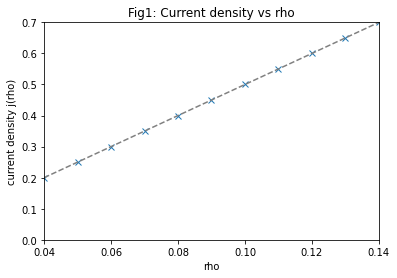

In [62]:
# Plotting.
plt.plot(list(results.keys()), list(results.values()), 'x')
plt.plot([RHO_MIN, RHO_MAX], [RHO_MIN * V_MAX, RHO_MAX * V_MAX], '--', color='grey')
plt.xlim([RHO_MIN, RHO_MAX])
plt.ylim([0, RHO_MAX * V_MAX])
plt.title('Fig{}: Current density vs rho'.format(1))
plt.xlabel('rho')
plt.ylabel('current density j(rho)')
plt.show()

## Simulating traffic evolution with initial constraint of rho=0.14



In [28]:
L = 1000 # Taking a smaller L to keep things simple.
rho = 0.14
V = []
Ng = []

out = simulation(rho=rho, test=0, save_run=True)

len(V), len(Ng)

Running simulation for rho = 0.14
{'Early stopping triggered at iteration 338 for rho=0.14.'}


(340, 340)

In [0]:
Vmat = np.r_[V].reshape((len(V), np.int(rho * L))).astype(int)
Ngmat = np.r_[Ng].reshape(len(Ng), np.int(rho * L)).astype(int)

road_history = np.zeros((len(V), int(3 * L + 30)), dtype=int)

assert np.all(Vmat[0, :] == V[0])
assert np.all(Vmat[-1, :] == V[-1])
assert np.all(Ngmat[0, :] == Ng[0])
assert np.all(Ngmat[-1, :] == Ng[-1])

In [0]:
def get_history(Vmat, Ngmat):
  

  num_of_cars = np.int(rho * L)
  iterations = Vmat.shape[0] # no. of iterations from simulation.

  # Matrix to store position index of each car on the road.
  # Each row represents each iteration.
  pos_history = np.zeros((iterations, num_of_cars), dtype=int)

  for car in range(0, num_of_cars):

    # When we try to update the position of the leftmost car on the road,
    # it moves quite far over each iteration and thereby we end up with 
    # a huge road since beginning of time. 
    # Instead, we keep the right most car fixed and study the rest of the traffic
    # with respoect to the rightmost car.  

    if car == 0:
      pos_history[:, car] = np.cumsum(Vmat[:, 0])
      continue
    
    # Update a given car's position as previous car's position + 
    # previous car's gap
    pos_history[:, car] = pos_history[:, car-1] + Ngmat[:, car-1]

  # make sure that the final position of leftmost car at the end of all
  # iterations is below 2L (a heuristic for sanity check. :) )
  # assert np.all(pos_history <= (L + 5 * iterations))

  road_history = np.zeros((Vmat.shape[0], np.max(pos_history) + 1), dtype=int)

  # Set the position equal to 1 on the road for each iteration.
  for row in range(iterations):
    road_history[row, pos_history[row]] = 1
  
  # Returning pos_history for debugging purposes. Otherwise, we are interested
  # in road_history only.
  return pos_history, road_history

In [0]:
_, road_history = get_history(Vmat, Ngmat)

<Figure size 1440x720 with 0 Axes>

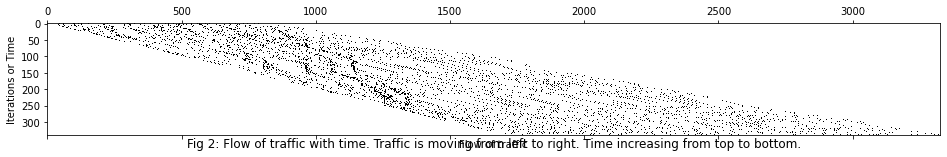

In [63]:
title_text = """Fig {}: Flow of traffic with time. \
Traffic is moving from left to right. \
Time increasing from top to bottom.""".format(2)

plt.figure(figsize=(20, 10))
plt.matshow(road_history, cmap='Greys', aspect='auto')
plt.xlabel('Flow of traffic')
plt.ylabel('Iterations or Time')
plt.title(title_text, y=-.16)
plt.show()

<Figure size 1440x720 with 0 Axes>

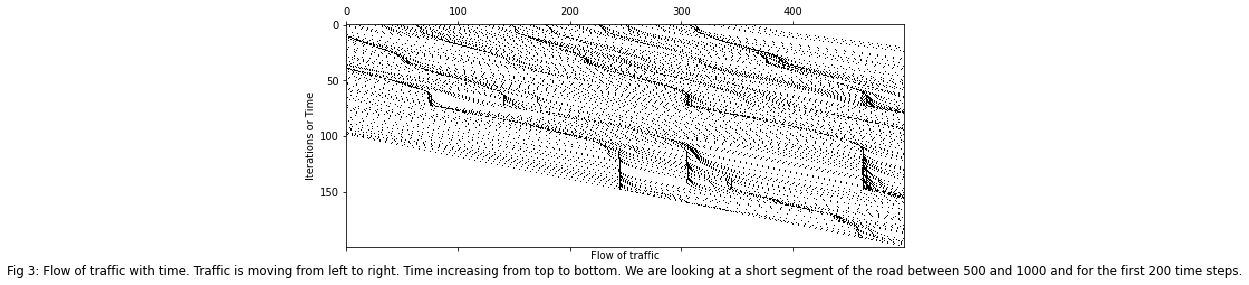

In [59]:
title_text = """Fig {}: Flow of traffic with time. \
Traffic is moving from left to right. \
Time increasing from top to bottom. \
We are looking at a short segment of the road between 500 and 1000 \
and for the first 200 time steps.""".format(3)

plt.figure(figsize=(20, 10))
plt.matshow(road_history[:200, 500:1000], cmap='Greys')
plt.xlabel('Flow of traffic')
plt.ylabel('Iterations or Time')
plt.title(title_text, y=-.15)
plt.show()